# **Canada Census Data**

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, Birch
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import numpy as np
import seaborn as sns
import plotly.express as px

In [ ]:
train = pd.read_csv('CensusCanada2021Training.csv')
test = pd.read_csv('CensusCanada2021Test.csv')

In [ ]:
random_state = 42

In [ ]:
train.head()

,Total Population,Total Households,Median Household Income (Current Year $),Total Households For Period Of Construction,Total Households For Period Of Construction Built Before 1961,Total Households For Period Of Construction Built Between 1961 And 1980,Total Households For Period Of Construction Built Between 1981 And 190,Total Households For Period Of Construction Built Between 1991 And 2000,Total Households For Period Of Construction Built Between 2001 And 2005,Total Households For Period Of Construction Built Between 2006 And 2010,Total Households For Period Of Construction Built Between 2011 And 2015,Total Households For Period Of Construction Built Between 2016 And 2021,Total Households For Structure Type Houses,"Total Households For Structure Type Apartment, Building Low And High Rise",Total Households For Structure Type Other Dwelling Types,Total Households for Tenure,Dwellings by Tenure Owner,Dwellings by Tenure Renter
0,3088,1235.0,107000.0,1235.0,25.0,1130.0,50.0,15.0,10.0,10.0,0.0,0.0,1135,130,0,1235.0,1055.0,180.0
1,5889,1665.0,111000.0,1665.0,0.0,0.0,0.0,15.0,20.0,375.0,315.0,935.0,1605,50,10,1665.0,1365.0,300.0
2,8090,2775.0,105000.0,2775.0,105.0,150.0,240.0,1210.0,555.0,165.0,240.0,120.0,2375,400,0,2775.0,2360.0,420.0
3,4074,1775.0,65000.0,1775.0,210.0,1100.0,260.0,85.0,35.0,45.0,30.0,15.0,1265,275,235,1775.0,1375.0,400.0
4,3642,1385.0,101000.0,1385.0,10.0,190.0,1010.0,165.0,0.0,0.0,10.0,0.0,1035,325,25,1385.0,1250.0,140.0


## **Step 1: Data Preprocessing and Data Exploration**
- clean `train` and `test`
- `test` is missing the median income field

### **1.1 Drop missing values**

In [ ]:
train.info()  # missing values detected in train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5371 entries, 0 to 5370
Data columns (total 18 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   Total Population                                                           5371 non-null   int64  
 1   Total Households                                                           5297 non-null   float64
 2   Median Household Income (Current Year $)                                   5245 non-null   float64
 3   Total Households For Period Of Construction                                5297 non-null   float64
 4   Total Households For Period Of Construction Built Before 1961              5297 non-null   float64
 5   Total Households For Period Of Construction Built Between 1961 And 1980    5297 non-null   float64
 6   Total Households For Period Of Construction Built Betwee

In [ ]:
# 2% of data missing incomes in train -> drop the rows
(5371 - 5245) / 5371 * 100

2.3459318562651275

In [ ]:
train.dropna(subset=['Median Household Income (Current Year $)'], inplace=True)

In [ ]:
print(train.shape)
print(test.shape)

(5245, 18)
(855, 17)


### **1.2 Explore the target variable**

In [ ]:
train['Median Household Income (Current Year $)'].describe()

,Median Household Income (Current Year $)
count,5245.000000
mean,80443.679695
std,23524.348532
min,23400.000000
25%,62800.000000
50%,78000.000000
75%,96000.000000
max,240000.000000


### **1.3 Population size and Household size**
- Total Population
- Total Households

These columns are basically the same as `Total Households`. Drop them.

In [ ]:
print(sum(train['Total Households'].values == train['Total Households for Tenure'].values))
print(sum(test['Total Households'].values == test['Total Households for Tenure'].values))

5245
855


In [ ]:
train.drop(columns=['Total Households for Tenure'], inplace=True)
test.drop(columns=['Total Households for Tenure'], inplace=True)

In [ ]:
print(sum(train['Total Households'].values == train['Total Households For Period Of Construction'].values))
print(sum(test['Total Households'].values == test['Total Households For Period Of Construction'].values))

5245
855


In [ ]:
train.drop(columns=['Total Households For Period Of Construction'], inplace=True)
test.drop(columns=['Total Households For Period Of Construction'], inplace=True)

- Total Households and Total Population show weak relationships with the target variable, but they are strongly correlated with each other.

- In our business case, the customer unit is "household".

- Therefore, drop `Total population`

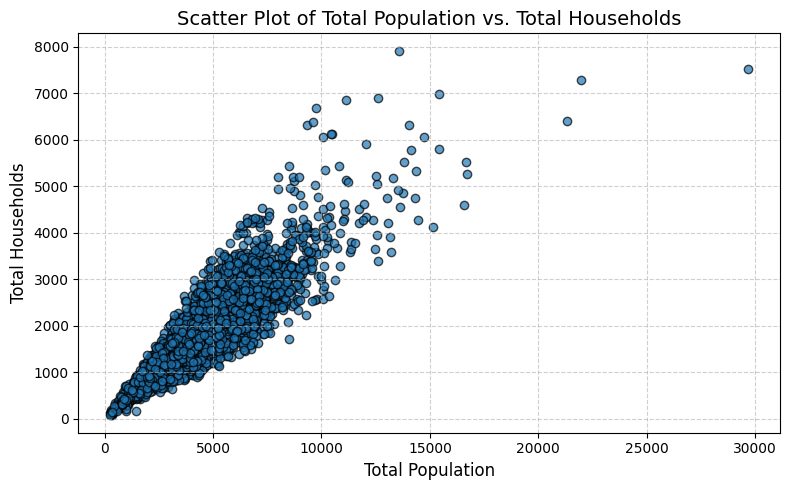

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(train['Total Population'], train['Total Households'], alpha=0.7, edgecolors='k')

plt.title('Scatter Plot of Total Population vs. Total Households', fontsize=14)
plt.xlabel('Total Population', fontsize=12)
plt.ylabel('Total Households', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
# correlation between household income, total household, total population
train[['Total Households', 'Total Population', 'Median Household Income (Current Year $)']].corr()

,Total Households,Total Population,Median Household Income (Current Year $)
Total Households,1.000000,0.884362,-0.151463
Total Population,0.884362,1.000000,0.147750
Median Household Income (Current Year $),-0.151463,0.147750,1.000000


In [ ]:
train.drop(columns=['Total Population'], inplace=True)
test.drop(columns=['Total Population'], inplace=True)

Due to the weak relationship between Total Households and Income, onvert all `Total Households` related variables into `Percentage Households` for comparisons.

In [ ]:
def convert_to_percent(df):
  # period of construction
  df['percent_b461'] = df['Total Households For Period Of Construction Built Before 1961'] / df['Total Households']
  df['percent_6180'] = df['Total Households For Period Of Construction Built Between 1961 And 1980'] / df['Total Households']
  df['percent_8190'] = df['Total Households For Period Of Construction Built Between 1981 And 190'] / df['Total Households']
  df['percent_9100'] = df['Total Households For Period Of Construction Built Between 1991 And 2000'] / df['Total Households']
  df['percent_0105'] = df['Total Households For Period Of Construction Built Between 2001 And 2005'] / df['Total Households']
  df['percent_0610'] = df['Total Households For Period Of Construction Built Between 2006 And 2010'] / df['Total Households']
  df['percent_1115'] = df['Total Households For Period Of Construction Built Between 2011 And 2015'] / df['Total Households']
  df['percent_1621'] = df['Total Households For Period Of Construction Built Between 2016 And 2021'] / df['Total Households']

  # structure type
  df['percent_house'] = df['Total Households For Structure Type Houses'] / df['Total Households']
  df['percent_apartment'] = df['Total Households For Structure Type Apartment, Building Low And High Rise'] / df['Total Households']
  df['percent_other'] = df['Total Households For Structure Type Other Dwelling Types'] / df['Total Households']

  # Tenure
  df['percent_owner'] = df['Dwellings by Tenure Owner'] / df['Total Households']
  df['percent_renter'] = df['Dwellings by Tenure Renter'] / df['Total Households']

convert_to_percent(train)
convert_to_percent(test)

In [ ]:
train.drop(train.columns[2:15], axis=1, inplace=True)
test.drop(test.columns[1:14], axis=1, inplace=True)

### **1.4 Dwellings by Tenure**
- percent_owner
- percent_renter

In [ ]:
train[['percent_owner', 'percent_renter', 'Median Household Income (Current Year $)']].corr()

,percent_owner,percent_renter,Median Household Income (Current Year $)
percent_owner,1.000000,-0.988496,0.758808
percent_renter,-0.988496,1.000000,-0.754533
Median Household Income (Current Year $),0.758808,-0.754533,1.000000


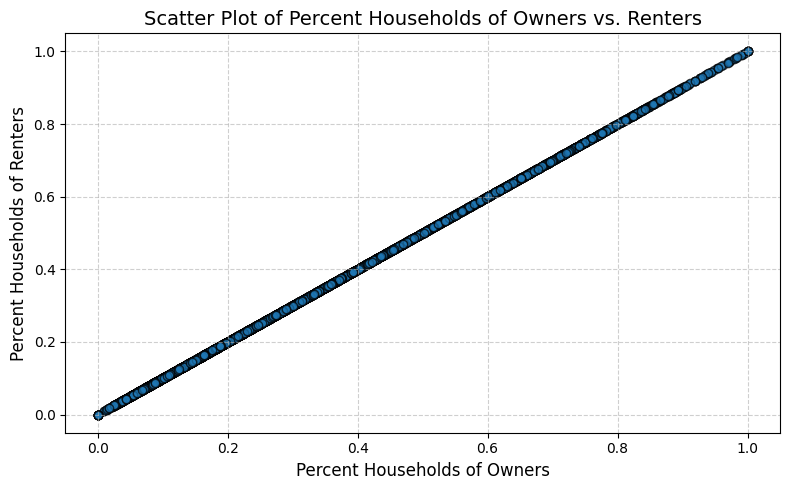

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(train['percent_renter'], train['percent_renter'], alpha=0.7, edgecolors='k')

plt.title('Scatter Plot of Percent Households of Owners vs. Renters', fontsize=14)
plt.xlabel('Percent Households of Owners', fontsize=12)
plt.ylabel('Percent Households of Renters', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
# strongly correlated with each other.
# In our business case, our customers are mainly the households owning properties.
# Drop percent_renter
train.drop(columns=['percent_renter'], inplace=True)
test.drop(columns=['percent_renter'], inplace=True)

### **1.5 Dwellings by Structure Type**
- percent_house
- percent_apartment
- percent_other

In [ ]:
train[['percent_house', 'percent_apartment', 'percent_other', 'Median Household Income (Current Year $)']].corr()

,percent_house,percent_apartment,percent_other,Median Household Income (Current Year $)
percent_house,1.000000,-0.989209,-0.002205,0.685660
percent_apartment,-0.989209,1.000000,-0.138266,-0.676938
percent_other,-0.002205,-0.138266,1.000000,-0.032396
Median Household Income (Current Year $),0.685660,-0.676938,-0.032396,1.000000


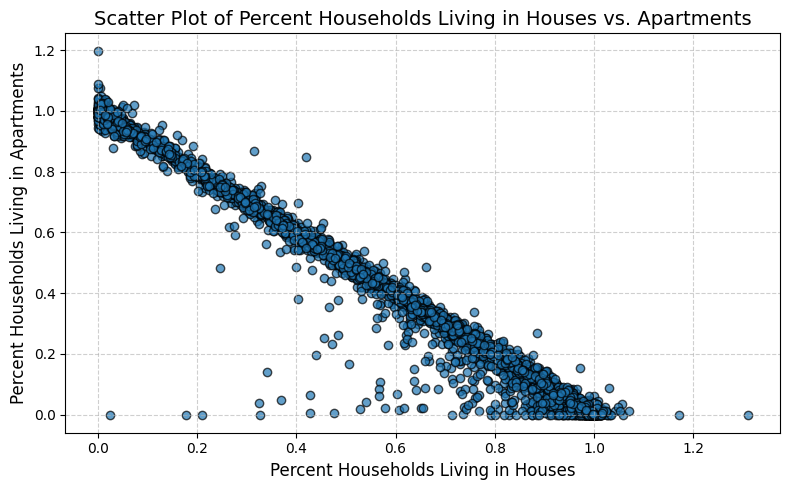

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(train['percent_house'], train['percent_apartment'], alpha=0.7, edgecolors='k')

plt.title('Scatter Plot of Percent Households Living in Houses vs. Apartments', fontsize=14)
plt.xlabel('Percent Households Living in Houses', fontsize=12)
plt.ylabel('Percent Households Living in Apartments', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
# strongly correlated with each other.
# percent_house and percent_apartment represent contrasting trends, mostly serving as inversely related measures
# Drop percent_apartment
train.drop(columns=['percent_apartment'], inplace=True)
test.drop(columns=['percent_apartment'], inplace=True)

### **1.6 Dwellings by Period of Constructions**
- No high correlation detected. Keep all.

In [ ]:
periods = ['percent_b461', 'percent_6180', 'percent_8190', 'percent_9100', 'percent_0105', 'percent_0610', 'percent_1115', 'percent_1621']

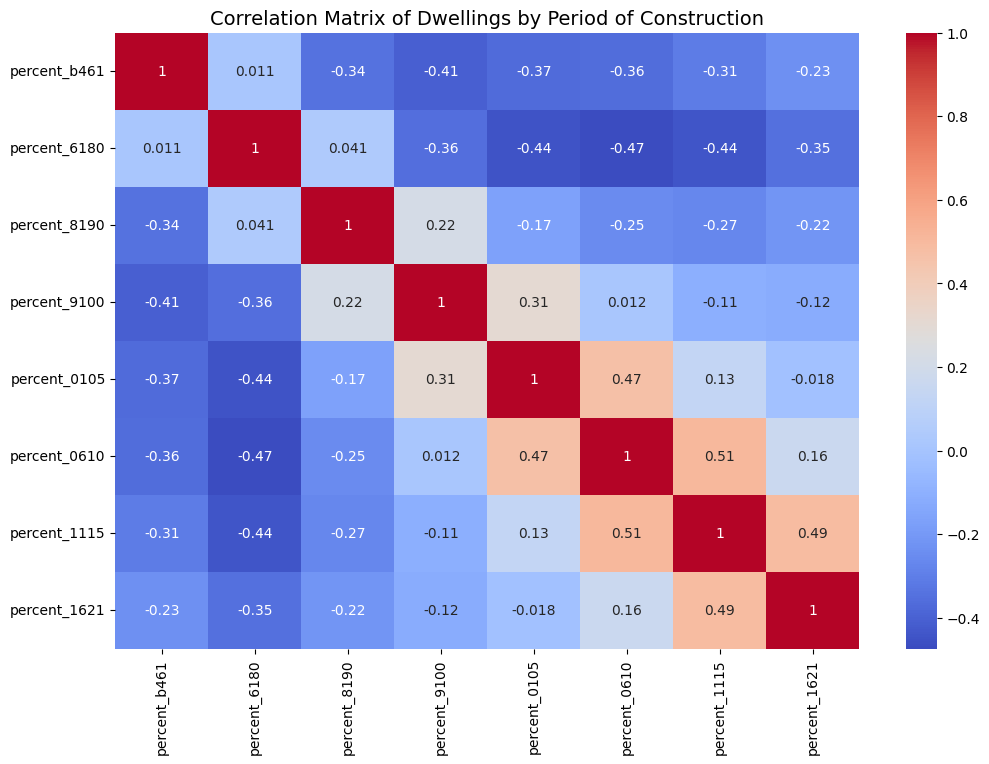

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Correlation Matrix of Dwellings by Period of Construction', fontsize=14)
sns.heatmap(train[periods].corr(), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
# create subplots scatter plot for all col in periods against median household income
train[periods + ["Median Household Income (Current Year $)"]].corr().iloc[:-1,-1]

,Median Household Income (Current Year $)
percent_b461,-0.333407
percent_6180,-0.314909
percent_8190,0.069976
percent_9100,0.263456
percent_0105,0.344923
percent_0610,0.286544
percent_1115,0.223251
percent_1621,0.113900


In [ ]:
# percent_b461 and percent_6180 vary in the same direction against median income
# the rest of variables vary in another direction
# combine percent_b461 and percent_6180 into percent_before_81
# combine the rest into percent_81_after
train['percent_before_81'] = train['percent_b461'] + train['percent_6180']
train['percent_81_after'] = train['percent_8190'] + train['percent_9100'] + train['percent_0105'] + train['percent_0610'] + train['percent_1115'] + train['percent_1621']
train.drop(columns=periods, inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5245 entries, 0 to 5370
Data columns (total 7 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Total Households                          5245 non-null   float64
 1   Median Household Income (Current Year $)  5245 non-null   float64
 2   percent_house                             5245 non-null   float64
 3   percent_other                             5245 non-null   float64
 4   percent_owner                             5245 non-null   float64
 5   percent_before_81                         5245 non-null   float64
 6   percent_81_after                          5245 non-null   float64
dtypes: float64(7)
memory usage: 327.8 KB


In [ ]:
test['percent_before_81'] = test['percent_b461'] + test['percent_6180']
test['percent_81_after'] = test['percent_8190'] + test['percent_9100'] + test['percent_0105'] + test['percent_0610'] + test['percent_1115'] + test['percent_1621']
test.drop(columns=periods, inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855 entries, 0 to 854
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Total Households   855 non-null    int64  
 1   percent_house      855 non-null    float64
 2   percent_other      855 non-null    float64
 3   percent_owner      855 non-null    float64
 4   percent_before_81  855 non-null    float64
 5   percent_81_after   855 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 40.2 KB


In [ ]:
train[['percent_before_81', 'percent_81_after', "Median Household Income (Current Year $)"]].corr()

,percent_before_81,percent_81_after,Median Household Income (Current Year $)
percent_before_81,1.000000,-0.999523,-0.456112
percent_81_after,-0.999523,1.000000,0.454334
Median Household Income (Current Year $),-0.456112,0.454334,1.000000


In [ ]:
# the two variables are highly correlated.
# In our business case, we care more about new constructions that require interior design
# Drop percent_before_81
train.drop(columns=['percent_before_81'], inplace=True)
test.drop(columns=['percent_before_81'], inplace=True)

### **1.7 Final Check for Correlations**

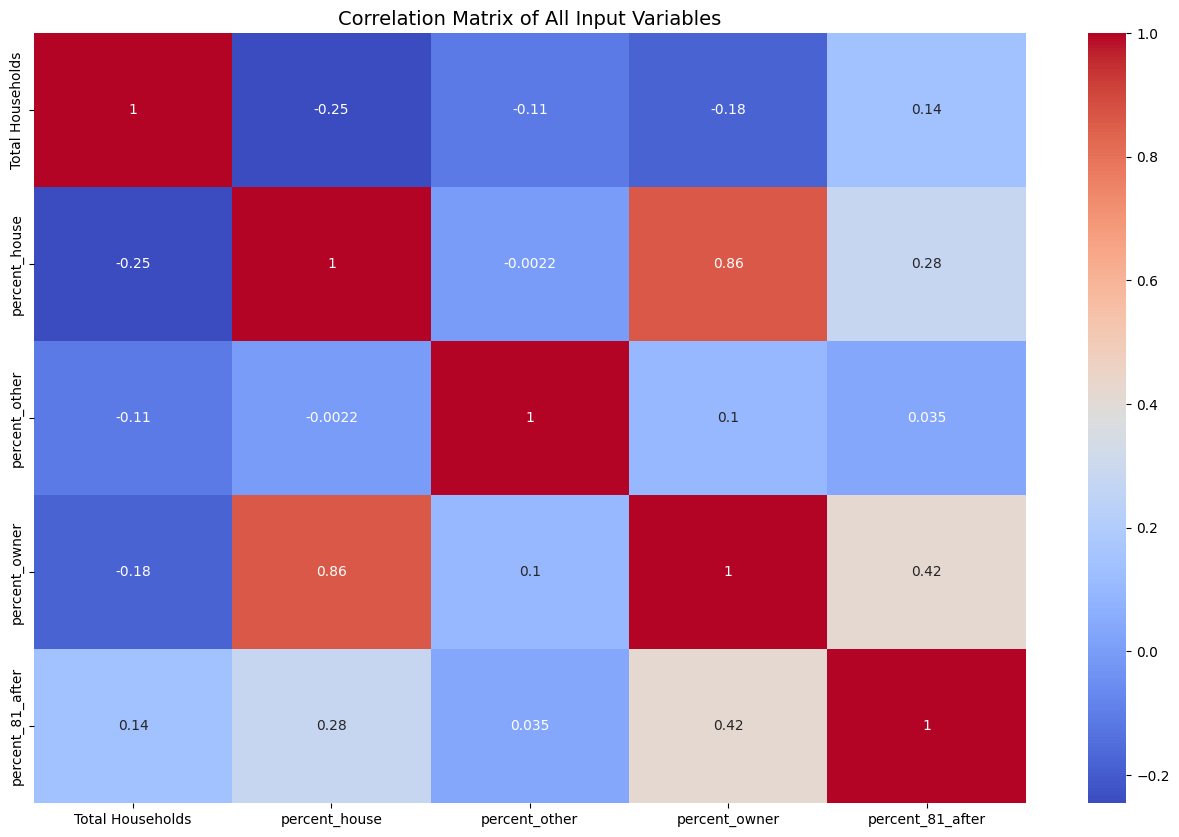

In [ ]:
# Correlation matrix for all predictors
plt.figure(figsize=(16, 10))
plt.title('Correlation Matrix of All Input Variables', fontsize=14)
correlation_matrix = train.drop(columns=["Median Household Income (Current Year $)"]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

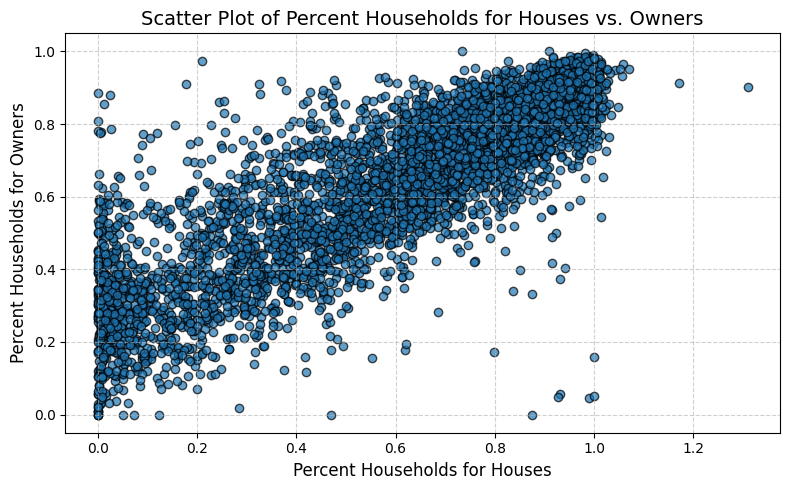

In [ ]:
# percent_owner and percent_house are highly correlated: 0.86
plt.figure(figsize=(8, 5))
plt.scatter(train['percent_house'], train['percent_owner'], alpha=0.7, edgecolors='k')

plt.title('Scatter Plot of Percent Households for Houses vs. Owners', fontsize=14)
plt.xlabel('Percent Households for Houses', fontsize=12)
plt.ylabel('Percent Households for Owners', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
# in our business case, we care more about structure type than tenure
# keep percent_house, drop percent_owner
train.drop(columns=['percent_owner'], inplace=True)
test.drop(columns=['percent_owner'], inplace=True)

- Train: 4 numeric predictors + 1 numeric target variable
- Test: 4 numeric predictors

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5245 entries, 0 to 5370
Data columns (total 5 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Total Households                          5245 non-null   float64
 1   Median Household Income (Current Year $)  5245 non-null   float64
 2   percent_house                             5245 non-null   float64
 3   percent_other                             5245 non-null   float64
 4   percent_81_after                          5245 non-null   float64
dtypes: float64(5)
memory usage: 245.9 KB


In [ ]:
test.shape

(855, 4)

### **1.8 Normalization**

- Normalize `Total Households` and `Median Household Income`, since clustering is sensitive to scaling. Use Min-Max Normalization

In [ ]:
train_scaled = train.copy()
test_scaled = test.copy()

scaler_HH = MinMaxScaler()
train_scaled['Total Households'] = scaler_HH.fit_transform(train[['Total Households']])
test_scaled['Total Households'] = scaler_HH.transform(test[['Total Households']])

scaler_Income = MinMaxScaler()
train_scaled['Median Household Income (Current Year $)'] = scaler_Income.fit_transform(train[['Median Household Income (Current Year $)']])

## **Step 2: K-Means Clustering - First Model**
- clean data are train_scaled and test_scaled

### **2.1 Pick the optimal k**
**Elbow Method:** Inertia (how much movements within the clusters)
- k = 2 ~ 6, the rate of decrease in Inertia slows significantly.


In [ ]:
inertias = []
k_values = range(1, 11)  # start with k between 1 to 10

for k in k_values:
    model = KMeans(n_clusters=k, random_state=random_state)
    model.fit(train_scaled)
    inertias.append(model.inertia_)

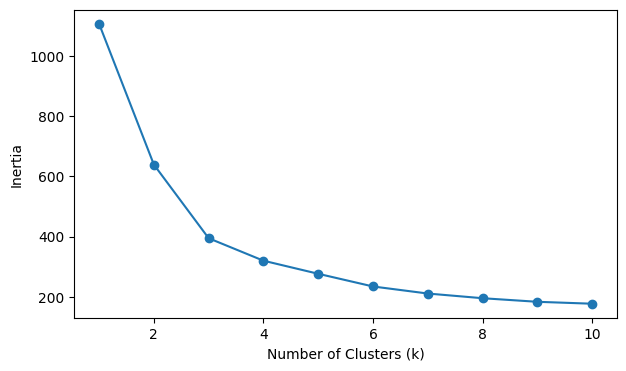

In [ ]:
plt.figure(figsize=(7, 4))
plt.plot(k_values, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

**Silhouette Score:** The Silhouette Score measures how well samples are clustered and separated from other clusters. Higher scores indicate better-defined clusters.
- Choose k between 2 and 6, detected by Elbow Methood
- **k = 3 has the highest Silhouette Score**

In [ ]:
silhouette_scores = []

for k in range(2, 7):
    model = KMeans(n_clusters=k, random_state=random_state)
    model.fit(train_scaled)
    score = silhouette_score(train_scaled, model.labels_)
    silhouette_scores.append(score)

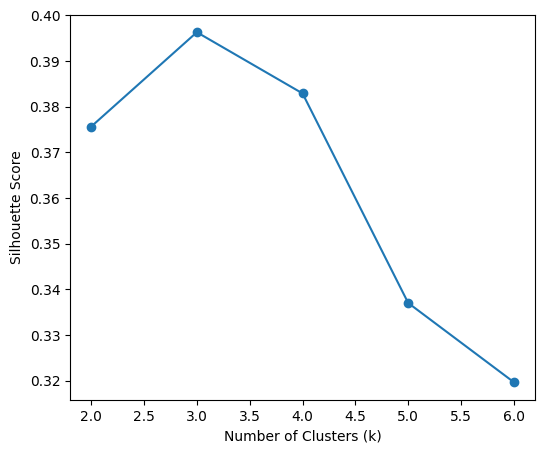

In [ ]:
plt.figure(figsize=(6, 5))
plt.plot(range(2, 7), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

**The Pseudo-F statistic:** Ratio of between-cluster to within-cluster variance. Higher values indicate well-separated and compact clusters.
- Choose k between 2 and 6.
- **k = 3 has the highest Pseudo-F statistic**

In [ ]:
F_scores = []

for k in range(2, 7):
    model = KMeans(n_clusters=k, random_state=random_state)
    model.fit(train_scaled)
    score = calinski_harabasz_score(train_scaled, model.labels_)
    F_scores.append(score)

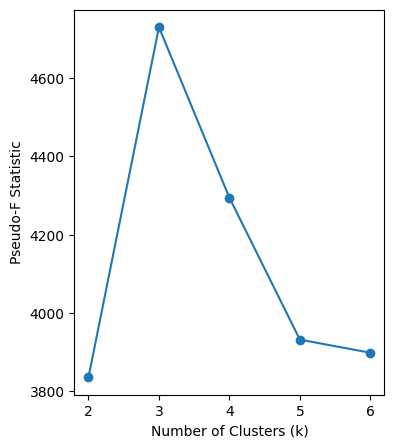

In [ ]:
plt.figure(figsize=(4, 5))
plt.plot(range(2, 7), F_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Pseudo-F Statistic')
plt.show()

### **2.2 Fit the K-means Model with optimal k = 3**

In [ ]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=random_state)
kmeans.fit(train_scaled)

KMeans(n_clusters=3, random_state=42)

In [ ]:
cluster_numbers = kmeans.fit_predict(train_scaled)
cluster_labels = [str(c) for c in cluster_numbers]

In [ ]:
centroids = kmeans.cluster_centers_
centroids = pd.DataFrame(centroids)
centroids.columns = train_scaled.columns

In [ ]:
train_kmeans = pd.concat([train_scaled, centroids])
labels = cluster_labels + ['Centroid 0', 'Centroid 1', 'Centroid 2']
train_kmeans['label'] = labels
train_kmeans['label'].value_counts()

,count
label,
1,1920
0,1807
2,1518
Centroid 0,1
Centroid 1,1
Centroid 2,1


## **Step 3: Develop a detailed profile of the three kmeans clusters**
- dataset including cluster results is called `train_kmeans`.

### **3.1 Aggregate statistics by cluster (mean)**
- Median Household Income, percent_house and percent_81_after differ significantly across 3 clusters.

In [ ]:
centroids

,Total Households,Median Household Income (Current Year $),percent_house,percent_other,percent_81_after
0,0.224890,0.344619,0.830333,0.014211,0.842894
1,0.194622,0.263739,0.751445,0.013462,0.295598
2,0.260053,0.165872,0.199837,0.010759,0.417948


In [ ]:
# convert total households and median household income back to original values
centroids['Total Households'] = scaler_HH.inverse_transform(centroids[['Total Households']])
centroids['Median Household Income (Current Year $)'] = scaler_Income.inverse_transform(centroids[['Median Household Income (Current Year $)']])

In [ ]:
centroids

,Total Households,Median Household Income (Current Year $),percent_house,percent_other,percent_81_after
0,1841.388736,98044.450580,0.830333,0.014211,0.842894
1,1605.000000,80525.873761,0.751445,0.013462,0.295598
2,2116.011866,59327.949901,0.199837,0.010759,0.417948


In [ ]:
centroids['Cluster'] = ['Cluster 0', 'Cluster 1', 'Cluster 2']

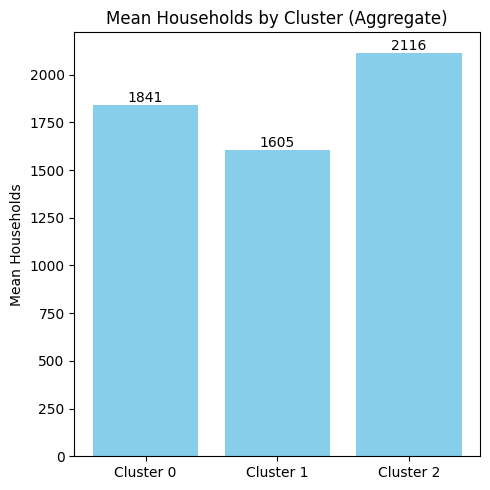

In [ ]:
plt.figure(figsize=(5, 5))
bars = plt.bar(centroids["Cluster"], centroids["Total Households"], color='skyblue')
plt.title("Mean Households by Cluster (Aggregate)")
plt.ylabel("Mean Households")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.0f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

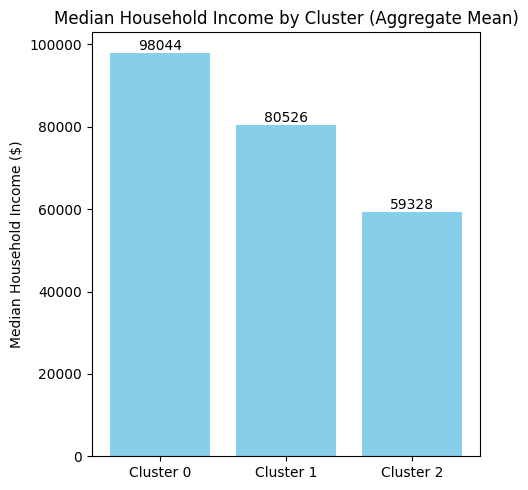

In [ ]:
plt.figure(figsize=(5, 5))
bars = plt.bar(centroids["Cluster"], centroids["Median Household Income (Current Year $)"], color='skyblue')
plt.title("Median Household Income by Cluster (Aggregate Mean)")
plt.ylabel("Median Household Income ($)")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.0f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
def aggregate_mean(col):

  plt.figure(figsize=(5, 4))
  bars = plt.bar(centroids["Cluster"], centroids[col], color='skyblue')
  plt.title(f"{col} by Cluster (Aggregate Mean)")
  plt.ylabel(f"{col}")

  for bar in bars:
      height = bar.get_height()
      plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

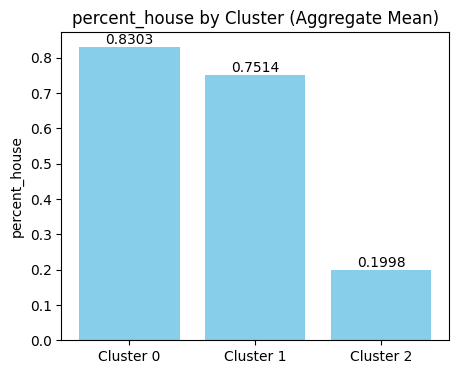

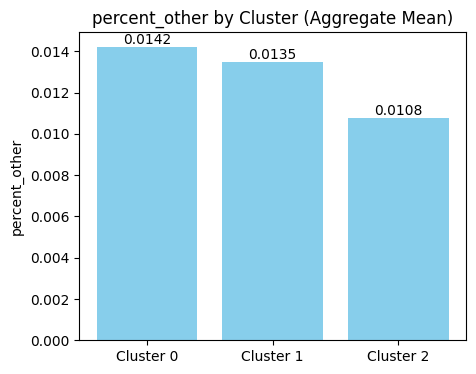

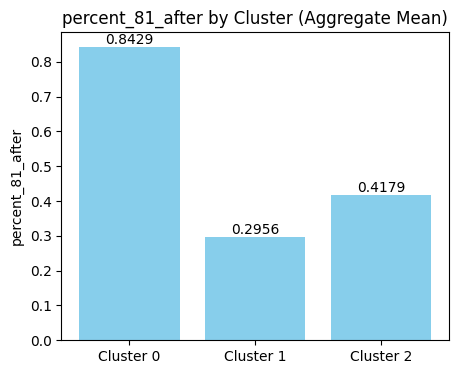

In [ ]:
for col in centroids.columns[2:-1]:
  aggregate_mean(col)

### **3.2 Cluster distribution by variable**
- Total Households
- Median Household Income (Current Year $)
- percent_house
- percent_other
- percent_81_after

In [ ]:
# convert total households and median household income back to original values
train_kmeans['Total Households'] = scaler_HH.inverse_transform(train_kmeans[['Total Households']])
train_kmeans['Median Household Income (Current Year $)'] = scaler_Income.inverse_transform(train_kmeans[['Median Household Income (Current Year $)']])

**Univariate: Dwellings related variables**

In [ ]:
def univariate_distribution(col):
  plt.figure(figsize=(10, 4))
  for cluster in ['0', '1', '2']:
      subset = train_kmeans[train_kmeans['label'] == cluster]
      plt.hist(subset[col], alpha=0.5, label=f'Cluster {cluster}')
  plt.title(f'Distribution of {col} by Cluster')
  plt.xlabel(col)
  plt.ylabel('Frequency')
  plt.legend()
  plt.show()

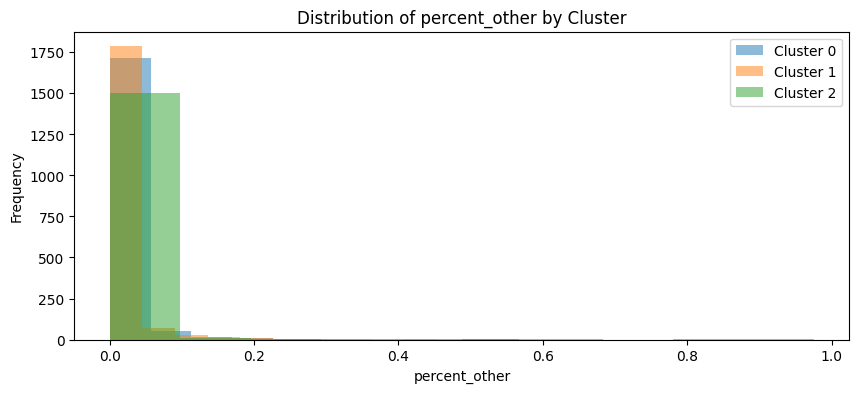

In [ ]:
univariate_distribution('percent_other')

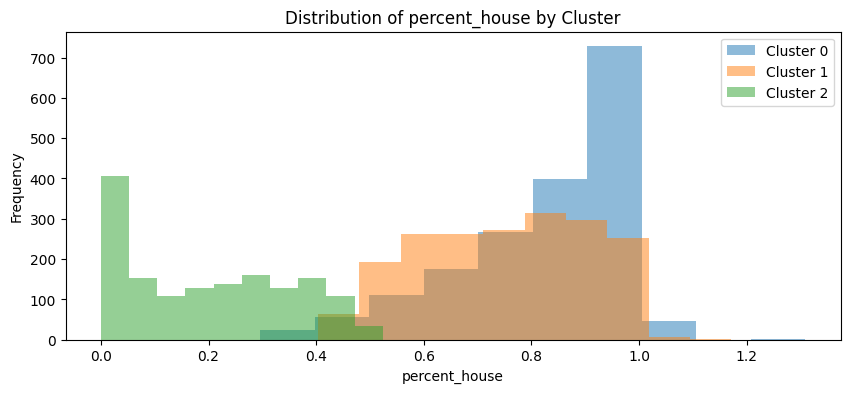

In [ ]:
univariate_distribution('percent_house')

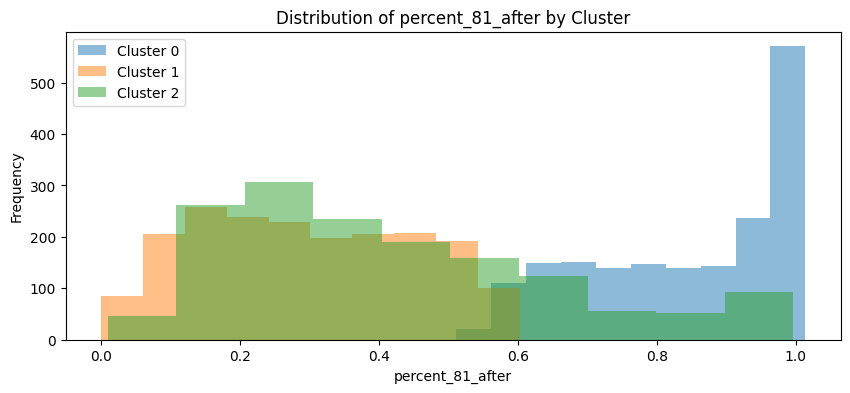

In [ ]:
univariate_distribution('percent_81_after')

**Multivariate: percent_house, percent_81_after**

In [ ]:
fig = px.scatter(train_kmeans, x='percent_house', y='percent_81_after',
                 color=labels,
                 width=800, height=600)
fig.update_traces(marker=dict(size=12))
fig.show()

**Univariate: Total Households and Median Household Income**

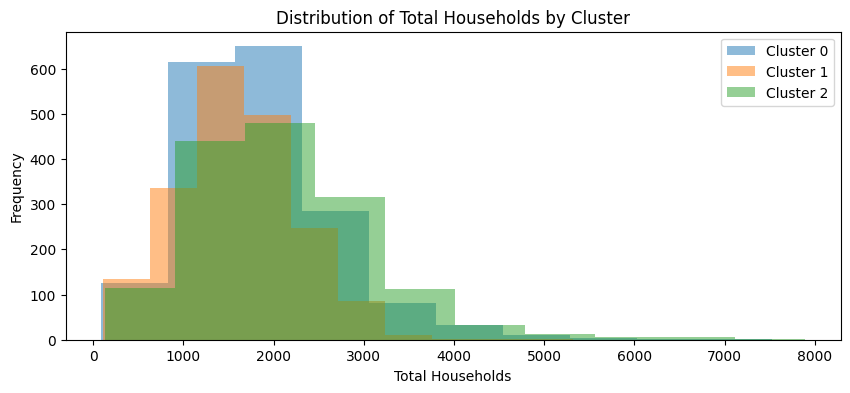

In [ ]:
univariate_distribution('Total Households')

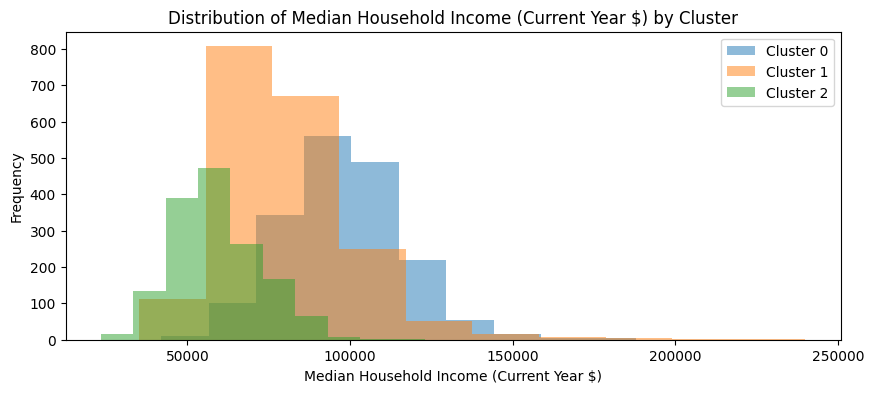

In [ ]:
univariate_distribution('Median Household Income (Current Year $)')

**Multivariate: Median houseohld Income and Total Households**

In [ ]:
fig = px.scatter(train_kmeans, x='Median Household Income (Current Year $)', y='Total Households',
                 color=labels,
                 width=800, height=600)
fig.update_traces(marker=dict(size=12))
fig.show()

**Multivariate: Three significant variables**
- Median household income
- percent_house
- percent_81_after

In [ ]:
fig = px.scatter_3d(train_kmeans.iloc[:-3,:], x='Median Household Income (Current Year $)',
                    y='percent_house', z='percent_81_after', color='label',
                    width=800, height=600)
fig.show()

## **Step 4: BIRCH Clustering - First Model**

In [ ]:
num_clusters = optimal_k

In [ ]:
param_grid = {
    'threshold': [0.3, 0.35, 0.4],
    'branching_factor': [2, 3, 4]}

# Grid search
best_score = -1
best_params = {}

for threshold in param_grid['threshold']:
    for branching_factor in param_grid['branching_factor']:

      birch = Birch(threshold=threshold, branching_factor=branching_factor,
                    n_clusters=num_clusters)
      birch.fit(train_scaled)
      labels = birch.predict(train_scaled)

      if len(set(labels)) > 1:
        score = silhouette_score(train_scaled, labels)
        if score > best_score:
          best_score = score
          best_params = {'threshold': threshold,
                        'branching_factor': branching_factor}

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning:

Number of subclusters found (2) by BIRCH is less than (3). Decrease the threshold.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning:

Number of subclusters found (2) by BIRCH is less than (3). Decrease the threshold.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning:

Number of subclusters found (2) by BIRCH is less than (3). Decrease the threshold.



In [ ]:
print("Best Parameters:", best_params)
print("Best Silhouette Score:", best_score)

Best Parameters: {'threshold': 0.35, 'branching_factor': 3}
Best Silhouette Score: 0.3953489843005805


In [ ]:
birch = Birch(n_clusters=num_clusters, branching_factor=3, threshold=0.35)
birch.fit(train_scaled)

Birch(branching_factor=3, threshold=0.35)

In [ ]:
cluster_labels  = birch.predict(train_scaled)
cluster_labels = [str(c) for c in cluster_labels]

In [ ]:
centroids_birch = birch.subcluster_centers_
centroids_birch = pd.DataFrame(centroids_birch)
centroids_birch.columns = train_scaled.columns

In [ ]:
train_birch = pd.concat([train_scaled, centroids_birch])
labels = cluster_labels + ['Centroid 0', 'Centroid 1', 'Centroid 2']
train_birch['label'] = labels

## **Step 5: Compare BIRCH clustering results with K-Means Clustering results**

### **5.1 Aggregate mean comparisons**

In [ ]:
# convert total households and median household income back to original values
centroids_birch['Total Households'] = scaler_HH.inverse_transform(centroids_birch[['Total Households']])
centroids_birch['Median Household Income (Current Year $)'] = scaler_Income.inverse_transform(centroids_birch[['Median Household Income (Current Year $)']])
centroids_birch

,Total Households,Median Household Income (Current Year $),percent_house,percent_other,percent_81_after
0,1599.965222,81335.259497,0.764483,0.013710,0.300589
1,1842.536558,98256.242970,0.830637,0.013975,0.847884
2,2099.602628,59581.914894,0.213838,0.010883,0.411659


In [ ]:
centroids # kmeans result

,Total Households,Median Household Income (Current Year $),percent_house,percent_other,percent_81_after,Cluster
0,1841.388736,98044.450580,0.830333,0.014211,0.842894,Cluster 0
1,1605.000000,80525.873761,0.751445,0.013462,0.295598,Cluster 1
2,2116.011866,59327.949901,0.199837,0.010759,0.417948,Cluster 2


### **5.2 Cluster distribution by variable**
- side by side boxplot for each variable

In [ ]:
train_birch['label'].value_counts()

,count
label,
2,1888
1,1784
0,1573
Centroid 0,1
Centroid 1,1
Centroid 2,1


In [ ]:
train_kmeans['label'].value_counts()

,count
label,
1,1920
0,1807
2,1518
Centroid 0,1
Centroid 1,1
Centroid 2,1


In [ ]:
# convert total households and median household income back to original values
train_birch['Total Households'] = scaler_HH.inverse_transform(train_birch[['Total Households']])
train_birch['Median Household Income (Current Year $)'] = scaler_Income.inverse_transform(train_birch[['Median Household Income (Current Year $)']])

In [ ]:
# group 1
cluster0_kmeans = train_kmeans[train_kmeans['label'] == '0']
cluster1_birch = train_birch[train_birch['label'] == '1']

# group 2
cluster1_kmeans = train_kmeans[train_kmeans['label'] == '1']
cluster2_birch = train_birch[train_birch['label'] == '2']

# group 3
cluster2_kmeans = train_kmeans[train_kmeans['label'] == '2']
cluster0_birch = train_birch[train_birch['label'] == '0']

In [ ]:
def side_by_side_boxplot(col, df1, df2):

    data = [df1[col], df2[col]]
    plt.figure(figsize=(4, 4))
    plt.boxplot(data, labels=['Kmeans', 'BIRCH'], patch_artist=True)
    plt.ylabel(col)
    plt.show()

In [ ]:
variables = ['Total Households', 'Median Household Income (Current Year $)', 'percent_house', 'percent_other', 'percent_81_after']

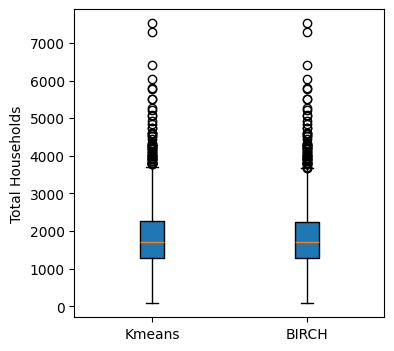

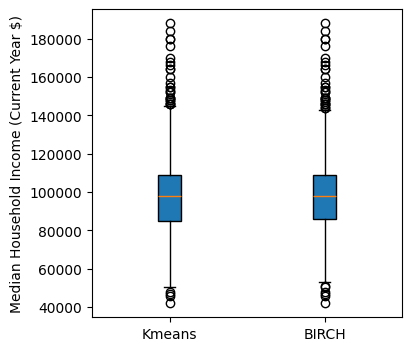

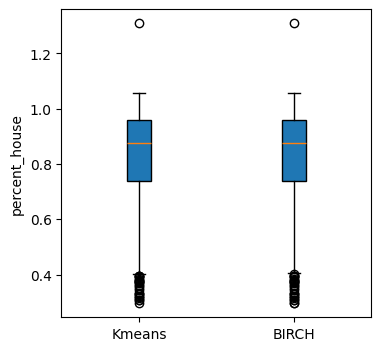

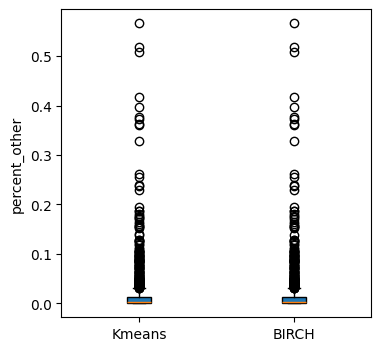

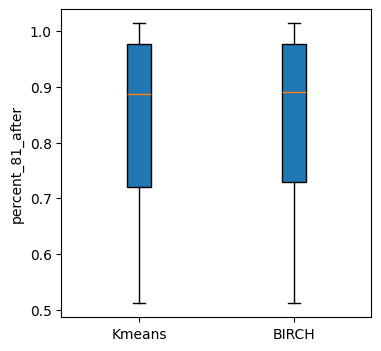

In [ ]:
# group 1
for var in variables:
  side_by_side_boxplot(var, cluster0_kmeans, cluster1_birch)

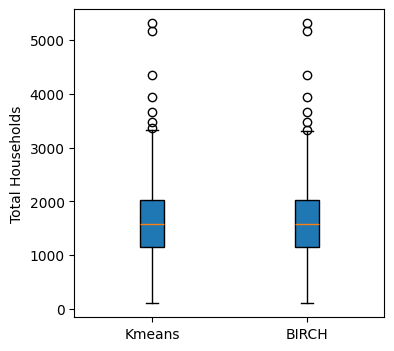

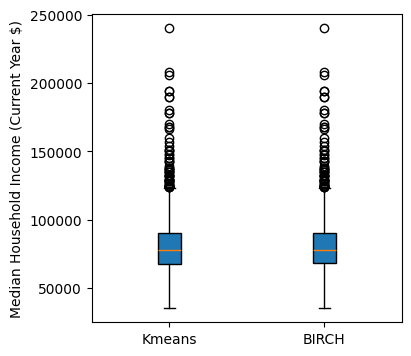

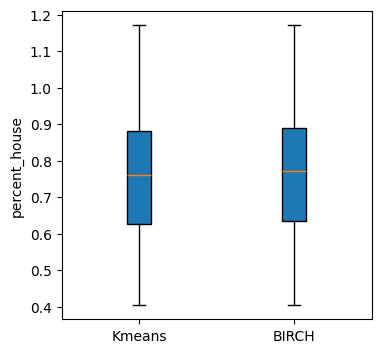

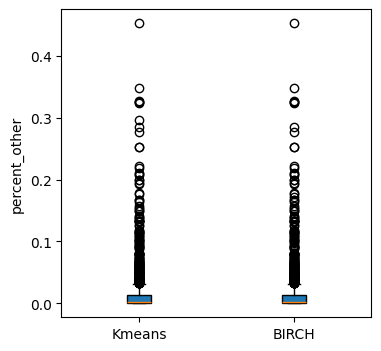

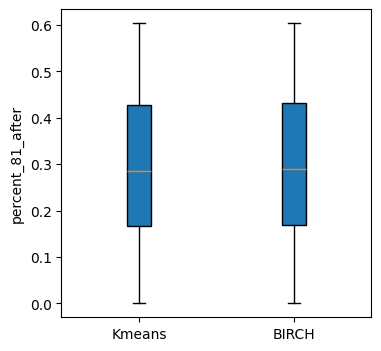

In [ ]:
# group 2
for var in variables:
  side_by_side_boxplot(var, cluster1_kmeans, cluster2_birch)

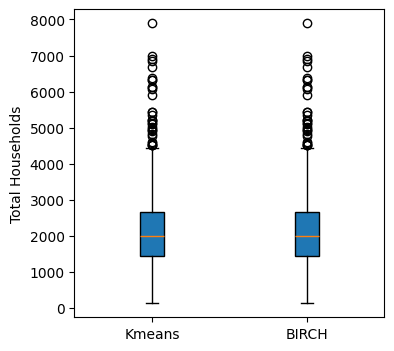

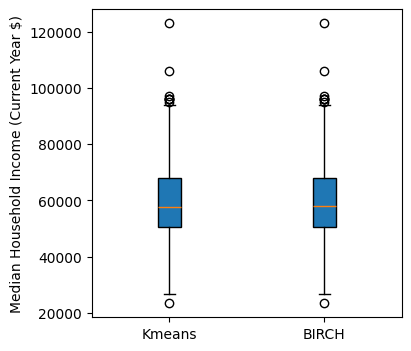

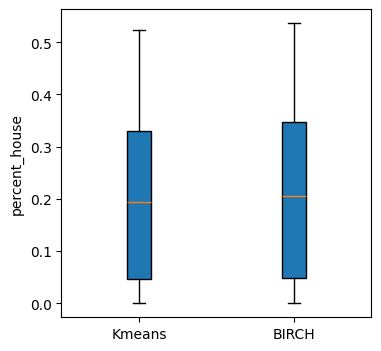

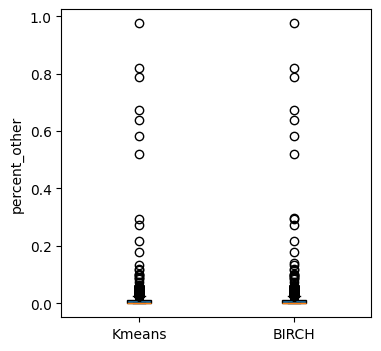

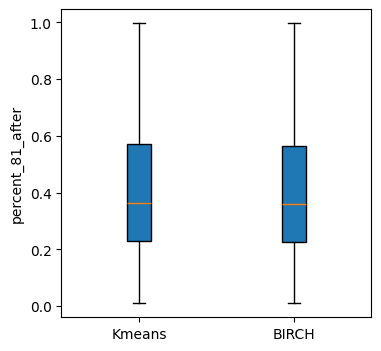

In [ ]:
# group 3
for var in variables:
  side_by_side_boxplot(var, cluster2_kmeans, cluster0_birch)

## **Step 6:Predictive Model**
- clean data are called train_scaled and test_scaled
- train_scaled contains 4 predictors + 1 target (median household income)
- test_scaled contains 4 predictors
- Both datasets have been carefully analyzed for correlations and normalized for consistency.

In [ ]:
train_labeled = train_kmeans[:-3]

train_labeled['Total Households'] = scaler_HH.fit_transform(train_labeled[['Total Households']])

train_labeled['Median Household Income (Current Year $)'] = scaler_Income.fit_transform(train[['Median Household Income (Current Year $)']])

train_labeled.head(20)

<ipython-input-84-76d2761f4bfb>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-84-76d2761f4bfb>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Total Households,Median Household Income (Current Year $),percent_house,percent_other,percent_81_after,label
0,0.147247,0.385965,0.919028,0.000000,0.068826,1
1,0.202305,0.404432,0.963964,0.006006,0.996997,0
2,0.344430,0.376731,0.855856,0.000000,0.911712,0
3,0.216389,0.192059,0.712676,0.132394,0.264789,1
4,0.166453,0.358264,0.747292,0.018051,0.855596,0
5,0.135723,0.353647,0.991266,0.008734,0.331878,1
6,0.223431,0.275162,0.139344,0.000000,0.226776,2
7,0.229834,0.335180,0.912234,0.013298,0.412234,1
8,0.153009,0.441367,0.832031,0.003906,0.808594,0
9,0.143406,0.120960,0.319502,0.000000,0.219917,2


In [ ]:
# group 1
cluster0 = train_labeled[train_labeled['label'] == '0']
cluster0=cluster0.drop(columns=['label'])
# group 2
cluster1 = train_labeled[train_labeled['label'] == '1']
cluster1=cluster1.drop(columns=['label'])
# group 3
cluster2 = train_labeled[train_labeled['label'] == '2']
cluster2=cluster2.drop(columns=['label'])

In [ ]:
cluster0.head()

,Total Households,Median Household Income (Current Year $),percent_house,percent_other,percent_81_after
1,0.202305,0.404432,0.963964,0.006006,0.996997
2,0.344430,0.376731,0.855856,0.000000,0.911712
4,0.166453,0.358264,0.747292,0.018051,0.855596
8,0.153009,0.441367,0.832031,0.003906,0.808594
10,0.195262,0.515235,0.990683,0.006211,0.968944


### **Neural Network**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


In [ ]:
X = train_labeled.drop(columns=['Median Household Income (Current Year $)'])
y = train_labeled['Median Household Income (Current Year $)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    Dense(32, activation='relu'),  # Hidden layer
    Dense(16, activation='relu'),  # Hidden layer
    Dense(1)  # Output layer (no activation for regression)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mae', metrics=['mae'])
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  # Adjust based on performance
    batch_size=32,
    verbose=1
)
y_test_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_test_pred)
print(f"Validation MAE: {mae:.2f}")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0811 - mae: 0.0811 - val_loss: 0.0414 - val_mae: 0.0414
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0440 - mae: 0.0440 - val_loss: 0.0402 - val_mae: 0.0402
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0438 - mae: 0.0438 - val_loss: 0.0400 - val_mae: 0.0400
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0424 - mae: 0.0424 - val_loss: 0.0403 - val_mae: 0.0403
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0410 - mae: 0.0410 - val_loss: 0.0414 - val_mae: 0.0414
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0440 - mae: 0.0440 - val_loss: 0.0397 - val_mae: 0.0397
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0426 - mae: 0.0426 - val_loss: 0.0391 - val_mae: 0.0391
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0422 - mae: 0.0422 - val_loss: 0.0449 - val_mae: 0.0449
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0417 - mae: 0.0417 - va

In [ ]:
X0=cluster0.drop(columns=['Median Household Income (Current Year $)'])
y0=cluster0['Median Household Income (Current Year $)']
X1=cluster1.drop(columns=['Median Household Income (Current Year $)'])
y1=cluster1['Median Household Income (Current Year $)']
X2=cluster2.drop(columns=['Median Household Income (Current Year $)'])
y2=cluster2['Median Household Income (Current Year $)']

In [ ]:
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.2, random_state=42)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [ ]:
model0 = Sequential([
    Dense(64, activation='relu', input_shape=(X0_train.shape[1],)),  # Input layer
    Dense(32, activation='relu'),  # Hidden layer
    Dense(16, activation='relu'),  # Hidden layer
    Dense(1)  # Output layer (no activation for regression)
])

model0.compile(optimizer=Adam(learning_rate=0.001), loss='mae', metrics=['mae'])
history0 = model0.fit(
    X0_train, y0_train,
    validation_data=(X0_test, y0_test),
    epochs=50,  # Adjust based on performance
    batch_size=32,
    verbose=1
)
y0_test_pred = model0.predict(X0_test).flatten()
mae0= mean_absolute_error(y0_test, y0_test_pred)
print(f"Validation MAE: {mae0:.4f}")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0793 - mae: 0.0793 - val_loss: 0.0536 - val_mae: 0.0536
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0485 - mae: 0.0485 - val_loss: 0.0561 - val_mae: 0.0561
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0496 - mae: 0.0496 - val_loss: 0.0535 - val_mae: 0.0535
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0528 - mae: 0.0528 - val_loss: 0.0594 - val_mae: 0.0594
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0537 - mae: 0.0537 - val_loss: 0.0520 - val_mae: 0.0520
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0488 - mae: 0.0488 - val_loss: 0.0512 - val_mae: 0.0512
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0479 - mae: 0.0479 - val_loss: 0.0511 - val_mae: 0.0511
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0484 - mae: 0.0484 - val_loss: 0.0548 - val_mae: 0.0548
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0501 - mae: 0.0501 - va

In [ ]:
model1 = Sequential([
    Dense(64, activation='relu', input_shape=(X1_train.shape[1],)),  # Input layer
    Dense(32, activation='relu'),  # Hidden layer
    Dense(16, activation='relu'),  # Hidden layer
    Dense(1)  # Output layer (no activation for regression)
])

model1.compile(optimizer=Adam(learning_rate=0.001), loss='mae', metrics=['mae'])
history1 = model1.fit(
    X1_train, y1_train,
    validation_data=(X0_test, y0_test),
    epochs=50,  # Adjust based on performance
    batch_size=32,
    verbose=1
)
y1_test_pred = model1.predict(X1_test).flatten()
mae1 = mean_absolute_error(y1_test, y1_test_pred)
print(f"Validation MAE: {mae1:.2f}")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1792 - mae: 0.1792 - val_loss: 0.0563 - val_mae: 0.0563
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0610 - mae: 0.0610 - val_loss: 0.0689 - val_mae: 0.0689
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0566 - mae: 0.0566 - val_loss: 0.0768 - val_mae: 0.0768
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0588 - mae: 0.0588 - val_loss: 0.0620 - val_mae: 0.0620
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0611 - mae: 0.0611 - val_loss: 0.0792 - val_mae: 0.0792
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0577 - mae: 0.0577 - val_loss: 0.0781 - val_mae: 0.0781
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0574 - mae: 0.0574 - val_loss: 0.0686 - val_mae: 0.0686
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0583 - mae: 0.0583 - val_loss: 0.0784 - val_mae: 0.0784
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0599 - mae: 0.0599 - va

In [ ]:
model2 = Sequential([
    Dense(64, activation='relu', input_shape=(X2_train.shape[1],)),  # Input layer
    Dense(32, activation='relu'),  # Hidden layer
    Dense(16, activation='relu'),  # Hidden layer
    Dense(1)  # Output layer (no activation for regression)
])

model2.compile(optimizer=Adam(learning_rate=0.001), loss='mae', metrics=['mae'])
history2 = model2.fit(
    X2_train, y2_train,
    validation_data=(X2_test, y2_test),
    epochs=50,  # Adjust based on performance
    batch_size=32,
    verbose=1
)
y2_test_pred = model2.predict(X2_test).flatten()
mae2 = mean_absolute_error(y2_test, y2_test_pred)
print(f"Validation MAE: {mae2:.2f}")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0617 - mae: 0.0617 - val_loss: 0.0424 - val_mae: 0.0424
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0437 - mae: 0.0437 - val_loss: 0.0406 - val_mae: 0.0406
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0429 - mae: 0.0429 - val_loss: 0.0410 - val_mae: 0.0410
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0426 - mae: 0.0426 - val_loss: 0.0407 - val_mae: 0.0407
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0418 - mae: 0.0418 - val_loss: 0.0399 - val_mae: 0.0399
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0426 - mae: 0.0426 - val_loss: 0.0410 - val_mae: 0.0410
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0439 - mae: 0.0439 - val_loss: 0.0399 - val_mae: 0.0399
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0430 - mae: 0.0430 - val_loss: 0.0394 - val_mae: 0.0394
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0414 - mae: 0.0414 - v

In [ ]:
mse=mean_squared_error(y_test, y_test_pred)
print(f"MSE for Total: {mse:.2f}")
mse0=mean_squared_error(y0_test, y0_test_pred)
mse1=mean_squared_error(y1_test, y1_test_pred)
mse2=mean_squared_error(y2_test, y2_test_pred)
print(f"MSE for cluster 0: {mse0:.4f}")
print(f"MSE for cluster 1: {mse1:.4f}")
print(f"MSE for cluster 2: {mse2:.4f}")
print("MSE:",mse,mse0,mse1,mse2)
print(f"MAE for Total:{mae:2f}")
print(f"MAE for cluster 0: {mae0:.4f}")
print(f"MAE for cluster 1: {mae1:.4f}")
print(f"MAE for cluster 2: {mae2:.4f}")
print("MAE: ",mae,mae0,mae1,mae2)


MSE for Total: 0.00
MSE for cluster 0: 0.0054
MSE for cluster 1: 0.0083
MSE for cluster 2: 0.0026
MSE: 0.00472381685742587 0.005394749533629015 0.008328589098596895 0.002647225573140301
MAE for Total:0.049786
MAE for cluster 0: 0.0512
MAE for cluster 1: 0.0630
MAE for cluster 2: 0.0411
MAE:  0.04978632866719381 0.05123867354078209 0.06295970224654408 0.041059315175608464


In [ ]:
X0_weight=X0_train.shape[0]/(X0_train.shape[0]+X1_train.shape[0]+X2_train.shape[0])
X1_weight=X1_train.shape[0]/(X0_train.shape[0]+X1_train.shape[0]+X2_train.shape[0])
X2_weight=X2_train.shape[0]/(X0_train.shape[0]+X1_train.shape[0]+X2_train.shape[0])
#
MAE_cluster=X0_weight*mae0+X1_weight*mae1+X2_weight*mae2

print(MAE_cluster,mae)

0.05258450406205257 0.04978632866719381


### **CART Model using Global and Segmentation Modelling**

Adding cluster labels to train data using kmeans

In [ ]:
train_kmeans = train_kmeans.iloc[:-3]

train_labeled = train_kmeans

train_labeled['Total Households'] = scaler_HH.fit_transform(train_labeled[['Total Households']])

train_labeled['Median Household Income (Current Year $)'] = scaler_Income.fit_transform(train[['Median Household Income (Current Year $)']])

Split the train_labeled dataset into train and validation sets

In [ ]:
# Split into train and validation sets
from sklearn.model_selection import train_test_split
train, validation = train_test_split(train_labeled, test_size=0.2, random_state=random_state)

Hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

Global Model

In [ ]:
from sklearn.metrics import mean_absolute_error

# Features and target
X_train = train.drop(columns=['Median Household Income (Current Year $)'])
y_train = train['Median Household Income (Current Year $)']

X_valid = validation.drop(columns=['Median Household Income (Current Year $)'])  # Keep 'label'
y_valid = validation['Median Household Income (Current Year $)']

# Grid search for global model
global_grid = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)

# Fit grid search on the entire training data
global_grid.fit(X_train, y_train)

# Best model and parameters
best_global_model = global_grid.best_estimator_
print("Best Global Model Parameters:", global_grid.best_params_)

Best Global Model Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}


In [ ]:
# Evaluate on validation data
global_preds = best_global_model.predict(X_valid)
global_mae = mean_absolute_error(y_valid, global_preds)
print(f"Tuned Global Model MAE: {global_mae}")

Tuned Global Model MAE: 0.05271288492806731


Segmentation Modelling

In [ ]:
# segemntation modelling
clusters = train['label'].unique()
cluster_models = {}
cluster_mae = {}

for cluster in clusters:
    # Filter cluster-specific data
    train_cluster = train[train['label'] == cluster]
    valid_cluster = validation[validation['label'] == cluster]

    # Extract features and target
    X_train_cluster = train_cluster.drop(columns=['Median Household Income (Current Year $)'])
    y_train_cluster = train_cluster['Median Household Income (Current Year $)']

    X_valid_cluster = valid_cluster.drop(columns=['Median Household Income (Current Year $)'])
    y_valid_cluster = valid_cluster['Median Household Income (Current Year $)']

    # Grid search for the cluster-specific model
    cluster_grid = GridSearchCV(
        estimator=DecisionTreeRegressor(random_state=42),
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1
    )

    cluster_grid.fit(X_train_cluster, y_train_cluster)

    # Best model and parameters
    best_cluster_model = cluster_grid.best_estimator_
    cluster_models[cluster] = best_cluster_model

    print(f"Best Parameters for Cluster {cluster}:", cluster_grid.best_params_)

    # Evaluate on validation data
    cluster_preds = best_cluster_model.predict(X_valid_cluster)
    cluster_mae[cluster] = mean_absolute_error(y_valid_cluster, cluster_preds)

print("Cluster-Specific MAE after Tuning:", cluster_mae)

Best Parameters for Cluster 2: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Parameters for Cluster 0: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best Parameters for Cluster 1: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
Cluster-Specific MAE after Tuning: {'2': 0.04173087514756395, '0': 0.050524974760431954, '1': 0.06488561995771557}


Check to see if Global Cluster model or Segmentation is preferred

In [ ]:
# Updated MAE values for each cluster
mae_cluster_0 = 0.05024974760431954
mae_cluster_1 = 0.06438561995771557
mae_cluster_2 = 0.04173887514756395

# Updated cluster sizes based on validation set
n_0 = 364  # Size of cluster 0
n_1 = 367  # Size of cluster 1
n_2 = 318  # Size of cluster 2

# Total size of the validation set
total_size = n_0 + n_1 + n_2

# Calculate weighted MAE
weighted_mae = (
    (mae_cluster_0 * n_0) +
    (mae_cluster_1 * n_1) +
    (mae_cluster_2 * n_2)
) / total_size

print(f"Weighted MAE for segmented models: {weighted_mae}")

Weighted MAE for segmented models: 0.05261524590026622


Weighted MAE for segmentation model is 0.0526 whereas global model was 0.0527 so we prefer segmentation modelling

### **K-nearest neighbours**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error

##### Global model

In [ ]:
X = train_scaled.loc[:, train_scaled.columns != "Median Household Income (Current Year $)"]

X

,Total Households,percent_house,percent_other,percent_81_after
0,0.147247,0.919028,0.000000,0.068826
1,0.202305,0.963964,0.006006,0.996997
2,0.344430,0.855856,0.000000,0.911712
3,0.216389,0.712676,0.132394,0.264789
4,0.166453,0.747292,0.018051,0.855596
...,...,...,...,...
5366,0.176056,0.534247,0.003425,0.986301
5367,0.526248,0.358760,0.001192,0.741359
5368,0.176056,0.835616,0.000000,0.236301
5369,0.138284,0.699571,0.012876,0.630901


In [ ]:
y = train_scaled.loc[:,["Median Household Income (Current Year $)"]]

y

,Median Household Income (Current Year $)
0,0.385965
1,0.404432
2,0.376731
3,0.192059
4,0.358264
...,...
5366,0.279778
5367,0.181902
5368,0.196676
5369,0.353647


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [ ]:
num_folds = 10
scoring = 'neg_mean_absolute_error'
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)
kfold.get_n_splits(X_train)

10

In [ ]:
for train_index, validate_index in kfold.split(train_scaled):
    print("TRAIN:", train_index, "VALIDATE:", validate_index)

TRAIN: [   0    1    2 ... 5242 5243 5244] VALIDATE: [   8   12   23   29   33   65   79   80   84   88   93  100  106  107
  109  132  144  149  151  157  167  168  179  199  227  228  230  239
  240  248  254  279  290  296  297  308  315  333  346  351  373  393
  410  416  418  422  426  437  438  439  465  468  471  472  485  486
  491  497  501  505  530  538  544  553  555  561  577  584  589  599
  624  642  653  654  677  681  683  705  711  721  724  733  734  742
  751  776  798  807  810  811  812  831  838  877  879  881  893  907
  915  926  931  932  964 1001 1002 1010 1029 1041 1055 1057 1094 1095
 1096 1101 1115 1117 1126 1128 1158 1181 1212 1221 1224 1235 1242 1260
 1292 1293 1321 1334 1360 1371 1391 1392 1397 1405 1419 1420 1421 1424
 1432 1433 1436 1438 1448 1451 1456 1467 1468 1477 1480 1483 1487 1498
 1499 1526 1532 1534 1543 1564 1566 1592 1595 1606 1611 1615 1616 1620
 1632 1634 1647 1657 1669 1691 1703 1718 1721 1730 1738 1743 1744 1746
 1747 1765 1769 1770 183

In [ ]:
cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

In [ ]:
msg = "KNN: %f (%f)" % (cv_results.mean(), cv_results.std())

In [ ]:
print(msg)

KNN: -0.055892 (0.003328)


In [ ]:
cv_results

array([-0.05476894, -0.05383459, -0.05198479, -0.06098404, -0.05259025,
       -0.05784879, -0.05426167, -0.06237227, -0.05647355, -0.05379999])

In [ ]:
k_values = np.arange(1,30)
param_grid = dict(n_neighbors = k_values)
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.051643 using {'n_neighbors': 29}


In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

-0.070781 (0.004294) with: {'n_neighbors': 1}
-0.061906 (0.004034) with: {'n_neighbors': 2}
-0.058961 (0.003130) with: {'n_neighbors': 3}
-0.057072 (0.003172) with: {'n_neighbors': 4}
-0.055892 (0.003328) with: {'n_neighbors': 5}
-0.054895 (0.003253) with: {'n_neighbors': 6}
-0.054198 (0.003443) with: {'n_neighbors': 7}
-0.053615 (0.003227) with: {'n_neighbors': 8}
-0.053352 (0.003319) with: {'n_neighbors': 9}
-0.053024 (0.003478) with: {'n_neighbors': 10}
-0.052910 (0.003346) with: {'n_neighbors': 11}
-0.052602 (0.003199) with: {'n_neighbors': 12}
-0.052532 (0.003194) with: {'n_neighbors': 13}
-0.052529 (0.003212) with: {'n_neighbors': 14}
-0.052445 (0.003237) with: {'n_neighbors': 15}
-0.052304 (0.003184) with: {'n_neighbors': 16}
-0.052216 (0.003173) with: {'n_neighbors': 17}
-0.052087 (0.003179) with: {'n_neighbors': 18}
-0.052061 (0.003101) with: {'n_neighbors': 19}
-0.052005 (0.003117) with: {'n_neighbors': 20}
-0.051964 (0.003164) with: {'n_neighbors': 21}
-0.051862 (0.003158) w

Text(0, 0.5, 'Negative mean squared error')

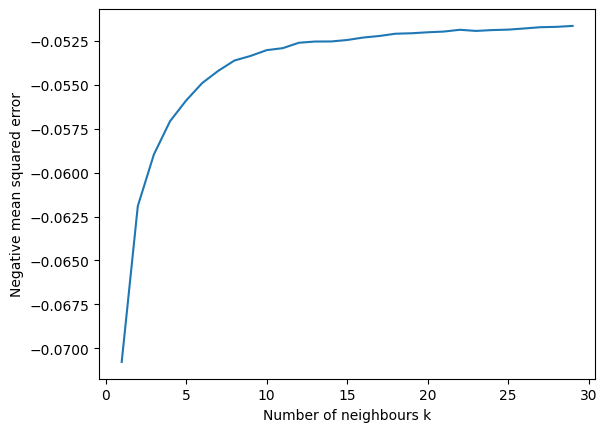

In [ ]:
plt.plot(k_values, means)
plt.xlabel("Number of neighbours k")
plt.ylabel("Negative mean squared error")

In [ ]:
model = KNeighborsRegressor(n_neighbors=29)
model.fit(X_train, y_train)
estimates = model.predict(X_test)

estimates

array([[0.27446111],
       [0.24976916],
       [0.216958  ],
       ...,
       [0.22549113],
       [0.35149807],
       [0.35205527]])

In [ ]:
mean_absolute_error(y_test, estimates)

0.05139573634301499

##### Cluster 0 Segmentation model

In [ ]:
cluster0 = train_labeled[train_labeled['label'] == '0']
cluster0 = cluster0.drop(['label'], axis=1)
cluster0.head()

,Total Households,Median Household Income (Current Year $),percent_house,percent_other,percent_81_after
1,0.202305,0.404432,0.963964,0.006006,0.996997
2,0.344430,0.376731,0.855856,0.000000,0.911712
4,0.166453,0.358264,0.747292,0.018051,0.855596
8,0.153009,0.441367,0.832031,0.003906,0.808594
10,0.195262,0.515235,0.990683,0.006211,0.968944


In [ ]:
X_cluster0 = cluster0.loc[:, cluster0.columns != "Median Household Income (Current Year $)"]

X_cluster0

,Total Households,percent_house,percent_other,percent_81_after
1,0.202305,0.963964,0.006006,0.996997
2,0.344430,0.855856,0.000000,0.911712
4,0.166453,0.747292,0.018051,0.855596
8,0.153009,0.832031,0.003906,0.808594
10,0.195262,0.990683,0.006211,0.968944
...,...,...,...,...
5362,0.220230,0.692521,0.000000,0.919668
5363,0.238156,0.825193,0.000000,0.794344
5364,0.244558,0.997494,0.000000,0.994987
5366,0.176056,0.534247,0.003425,0.986301


In [ ]:
y_cluster0 = cluster0.loc[:, ["Median Household Income (Current Year $)"]]

y_cluster0

,Median Household Income (Current Year $)
1,0.404432
2,0.376731
4,0.358264
8,0.441367
10,0.515235
...,...
5362,0.302862
5363,0.279778
5364,0.409049
5366,0.279778


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_cluster0, y_cluster0, test_size=0.2, random_state=random_state)

In [ ]:
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)
kfold.get_n_splits(X_train)

10

In [ ]:
cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
msg = "KNN: %f (%f)" % (cv_results.mean(), cv_results.std())
print(msg)

KNN: -0.052370 (0.003599)


In [ ]:
cv_results

array([-0.05799217, -0.05176171, -0.05265068, -0.05294488, -0.05730379,
       -0.05146584, -0.05350108, -0.04650726, -0.05317085, -0.04639761])

In [ ]:
k_values = np.arange(1,30)
param_grid = dict(n_neighbors = k_values)
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast



In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.048983 using {'n_neighbors': 17}


In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

-0.065319 (0.005553) with: {'n_neighbors': 1}
-0.057632 (0.004701) with: {'n_neighbors': 2}
-0.055691 (0.003232) with: {'n_neighbors': 3}
-0.053763 (0.003631) with: {'n_neighbors': 4}
-0.052370 (0.003599) with: {'n_neighbors': 5}
-0.051246 (0.003141) with: {'n_neighbors': 6}
-0.050582 (0.003497) with: {'n_neighbors': 7}
-0.049899 (0.003442) with: {'n_neighbors': 8}
-0.049440 (0.003369) with: {'n_neighbors': 9}
-0.049419 (0.003479) with: {'n_neighbors': 10}
-0.049208 (0.003449) with: {'n_neighbors': 11}
-0.049170 (0.003423) with: {'n_neighbors': 12}
-0.049153 (0.003385) with: {'n_neighbors': 13}
-0.049318 (0.003424) with: {'n_neighbors': 14}
-0.049084 (0.003439) with: {'n_neighbors': 15}
-0.049046 (0.003368) with: {'n_neighbors': 16}
-0.048983 (0.003291) with: {'n_neighbors': 17}
-0.049015 (0.003393) with: {'n_neighbors': 18}
-0.049052 (0.003218) with: {'n_neighbors': 19}
-0.049031 (0.003304) with: {'n_neighbors': 20}
-0.049028 (0.003196) with: {'n_neighbors': 21}
-0.049109 (0.003064) w

Text(0, 0.5, 'Negative mean absolute error')

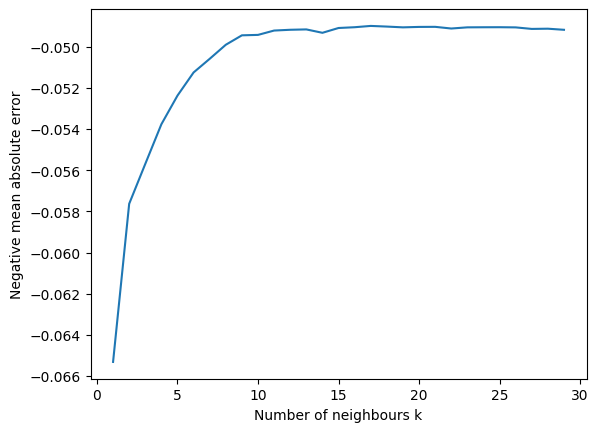

In [ ]:
plt.plot(k_values, means)
plt.xlabel("Number of neighbours k")
plt.ylabel("Negative mean absolute error")

In [ ]:
model = KNeighborsRegressor(n_neighbors=17)
model.fit(X_train, y_train)
estimates = model.predict(X_test)

estimates

array([[0.38813753],
       [0.44516865],
       [0.31331813],
       [0.23377329],
       [0.32132964],
       [0.42507197],
       [0.39058172],
       [0.42289935],
       [0.38542176],
       [0.27013742],
       [0.22826028],
       [0.26562924],
       [0.35364728],
       [0.25919287],
       [0.29715931],
       [0.40035848],
       [0.29457933],
       [0.4142089 ],
       [0.37483026],
       [0.32138396],
       [0.36624844],
       [0.39058172],
       [0.2219597 ],
       [0.34482103],
       [0.32540329],
       [0.27263592],
       [0.40524686],
       [0.43158981],
       [0.36369562],
       [0.37170713],
       [0.29851719],
       [0.2527565 ],
       [0.31399707],
       [0.3229591 ],
       [0.3721145 ],
       [0.36668296],
       [0.26256043],
       [0.3311064 ],
       [0.33925371],
       [0.42480039],
       [0.46933898],
       [0.38542176],
       [0.29675194],
       [0.33056325],
       [0.29851719],
       [0.40334583],
       [0.33395796],
       [0.458

In [ ]:
mean_absolute_error(y_test, estimates)

0.05114976003716251

##### Cluster 1 Segmentation model

In [ ]:
cluster1 = train_labeled[train_labeled['label'] == '1']
cluster1 = cluster1.drop(['label'], axis=1)
X_cluster1 = cluster1.loc[:, cluster1.columns != "Median Household Income (Current Year $)"]
y_cluster1 = cluster1.loc[:, ["Median Household Income (Current Year $)"]]

X_train, X_test, y_train, y_test = train_test_split(X_cluster1, y_cluster1, test_size=0.2, random_state=random_state)

In [ ]:
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)
kfold.get_n_splits(X_train)

10

In [ ]:
cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
msg = "KNN: %f (%f)" % (cv_results.mean(), cv_results.std())
print(msg)

KNN: -0.065853 (0.003996)


In [ ]:
cv_results

array([-0.05843916, -0.06398772, -0.06722068, -0.0715257 , -0.06859313,
       -0.07206893, -0.06220798, -0.06458337, -0.06344697, -0.06645544])

In [ ]:
k_values = np.arange(1,30)
param_grid = dict(n_neighbors = k_values)
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.059387 using {'n_neighbors': 29}


In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

-0.081466 (0.005156) with: {'n_neighbors': 1}
-0.072881 (0.004654) with: {'n_neighbors': 2}
-0.069043 (0.003726) with: {'n_neighbors': 3}
-0.066612 (0.003614) with: {'n_neighbors': 4}
-0.065853 (0.003996) with: {'n_neighbors': 5}
-0.063826 (0.004064) with: {'n_neighbors': 6}
-0.063385 (0.004103) with: {'n_neighbors': 7}
-0.062816 (0.003417) with: {'n_neighbors': 8}
-0.062089 (0.003474) with: {'n_neighbors': 9}
-0.061745 (0.003680) with: {'n_neighbors': 10}
-0.061371 (0.003511) with: {'n_neighbors': 11}
-0.061227 (0.003522) with: {'n_neighbors': 12}
-0.060832 (0.003726) with: {'n_neighbors': 13}
-0.060635 (0.003632) with: {'n_neighbors': 14}
-0.060677 (0.003453) with: {'n_neighbors': 15}
-0.060482 (0.003406) with: {'n_neighbors': 16}
-0.060341 (0.003312) with: {'n_neighbors': 17}
-0.060242 (0.003433) with: {'n_neighbors': 18}
-0.060043 (0.003508) with: {'n_neighbors': 19}
-0.059933 (0.003370) with: {'n_neighbors': 20}
-0.059965 (0.003158) with: {'n_neighbors': 21}
-0.059880 (0.003213) w

Text(0, 0.5, 'Negative mean absolute error')

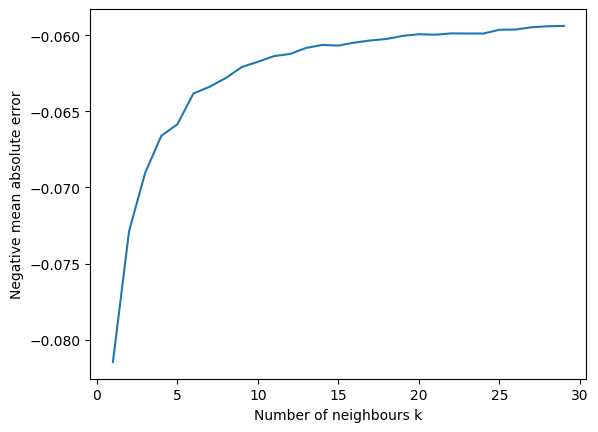

In [ ]:
plt.plot(k_values, means)
plt.xlabel("Number of neighbours k")
plt.ylabel("Negative mean absolute error")

In [ ]:
model = KNeighborsRegressor(n_neighbors=29)
model.fit(X_train, y_train)
estimates = model.predict(X_test)

In [ ]:
mean_absolute_error(y_test, estimates)

0.06396219559599241

##### Cluster 2 Segmentation Model

In [ ]:
cluster2 = train_labeled[train_labeled['label'] == '2']
cluster2 = cluster2.drop(['label'], axis=1)
X_cluster2 = cluster2.loc[:, cluster2.columns != "Median Household Income (Current Year $)"]
y_cluster2 = cluster2.loc[:, ["Median Household Income (Current Year $)"]]

X_train, X_test, y_train, y_test = train_test_split(X_cluster2, y_cluster2, test_size=0.2, random_state=random_state)

In [ ]:
cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
msg = "KNN: %f (%f)" % (cv_results.mean(), cv_results.std())
print(msg)

KNN: -0.042293 (0.002365)


In [ ]:
cv_results

array([-0.04211067, -0.04455935, -0.04360232, -0.04291241, -0.04232791,
       -0.0355494 , -0.04330929, -0.04201898, -0.04296602, -0.04357546])

In [ ]:
k_values = np.arange(1,30)
param_grid = dict(n_neighbors = k_values)
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.042220 using {'n_neighbors': 26}


In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

-0.056347 (0.004503) with: {'n_neighbors': 1}
-0.047987 (0.003273) with: {'n_neighbors': 2}
-0.045624 (0.003051) with: {'n_neighbors': 3}
-0.044830 (0.002253) with: {'n_neighbors': 4}
-0.044961 (0.001811) with: {'n_neighbors': 5}
-0.044492 (0.002185) with: {'n_neighbors': 6}
-0.043692 (0.002549) with: {'n_neighbors': 7}
-0.043723 (0.002367) with: {'n_neighbors': 8}
-0.043325 (0.002316) with: {'n_neighbors': 9}
-0.043260 (0.002205) with: {'n_neighbors': 10}
-0.043274 (0.002003) with: {'n_neighbors': 11}
-0.043279 (0.002146) with: {'n_neighbors': 12}
-0.042997 (0.002315) with: {'n_neighbors': 13}
-0.043009 (0.002436) with: {'n_neighbors': 14}
-0.042834 (0.002490) with: {'n_neighbors': 15}
-0.042652 (0.002376) with: {'n_neighbors': 16}
-0.042561 (0.002353) with: {'n_neighbors': 17}
-0.042538 (0.002327) with: {'n_neighbors': 18}
-0.042598 (0.002308) with: {'n_neighbors': 19}
-0.042509 (0.002324) with: {'n_neighbors': 20}
-0.042538 (0.002293) with: {'n_neighbors': 21}
-0.042358 (0.002322) w

Text(0, 0.5, 'Negative mean absolute error')

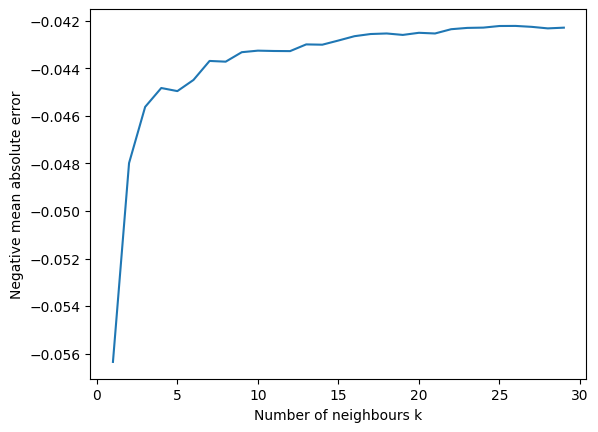

In [ ]:
plt.plot(k_values, means)
plt.xlabel("Number of neighbours k")
plt.ylabel("Negative mean absolute error")

In [ ]:
model = KNeighborsRegressor(n_neighbors=26)
model.fit(X_train, y_train)
estimates = model.predict(X_test)

In [ ]:
mean_absolute_error(y_test, estimates)

0.040433376884572395

MAE for global model and segmentation models:
- Global model: 0.05139573634301499
- Cluster0 model: 0.05114976003716251
- Cluster1 model: 0.06396219559599241
- Cluster2 model: 0.040433376884572395

In [ ]:
# Updated MAE values for each cluster
mae_cluster_0 = 0.05114976003716251
mae_cluster_1 = 0.06396219559599241
mae_cluster_2 = 0.040433376884572395

# Updated cluster sizes based on validation set
n_0 = 362  # Size of cluster 0
n_1 = 384  # Size of cluster 1
n_2 = 304  # Size of cluster 2

# Total size of the validation set
total_size = n_0 + n_1 + n_2

# Calculate weighted MAE
weighted_mae = (
    (mae_cluster_0 * n_0) +
    (mae_cluster_1 * n_1) +
    (mae_cluster_2 * n_2)
) / total_size

print(f"Weighted MAE for segmented models: {weighted_mae}")

Weighted MAE for segmented models: 0.05273280268116564


The weighted MAE for segmented models is 0.05273280268116564 which is greater than the MAE for global model, thus choose global model for KNN.

## **Step7: Predicting test data**

- Cluster 0: ANN
- Cluster 1: ANN
- Cluster 2: KNN

Test Data: Do kmeans to label data into clusters then do segemntation modelling to get prediction

In [ ]:
test_scaled

,Total Households,percent_house,percent_other,percent_81_after
0,0.526248,0.001192,0.000000,0.675805
1,0.438540,0.029915,0.021368,0.987179
2,0.371319,0.462312,0.005025,0.991625
3,0.072983,0.114504,0.030534,0.045802
4,0.195262,0.301242,0.000000,0.133540
...,...,...,...,...
850,0.036492,0.729730,0.054054,0.513514
851,0.230474,0.554377,0.000000,0.122016
852,0.118438,1.009901,0.000000,0.891089
853,0.204225,0.806548,0.020833,0.214286


In [ ]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=random_state)
kmeans.fit(test_scaled)

KMeans(n_clusters=3, random_state=42)

In [ ]:
cluster_numbers = kmeans.fit_predict(test_scaled)
cluster_labels = [str(c) for c in cluster_numbers]

test_kmeans = pd.concat([test_scaled])
labels = cluster_labels
test_kmeans['label'] = labels

add index to keep track of data

In [ ]:
test_kmeans['index'] = range(len(test_kmeans))

test_kmeans

,Total Households,percent_house,percent_other,percent_81_after,label,index
0,0.526248,0.001192,0.000000,0.675805,0,0
1,0.438540,0.029915,0.021368,0.987179,0,1
2,0.371319,0.462312,0.005025,0.991625,1,2
3,0.072983,0.114504,0.030534,0.045802,0,3
4,0.195262,0.301242,0.000000,0.133540,0,4
...,...,...,...,...,...,...
850,0.036492,0.729730,0.054054,0.513514,2,850
851,0.230474,0.554377,0.000000,0.122016,2,851
852,0.118438,1.009901,0.000000,0.891089,1,852
853,0.204225,0.806548,0.020833,0.214286,2,853


## **Step 8: Train The model using the whole training dataset**

In [ ]:
model0 = Sequential([
    Dense(64, activation='relu', input_shape=(X0.shape[1],)),  # Input layer
    Dense(32, activation='relu'),  # Hidden layer
    Dense(16, activation='relu'),  # Hidden layer
    Dense(1)  # Output layer (no activation for regression)
])

model0.compile(optimizer=Adam(learning_rate=0.001), loss='mae', metrics=['mae'])
history0 = model0.fit(
    X0, y0,
    validation_data=(X0_test, y0_test),
    epochs=50,  # Adjust based on performance
    batch_size=32,
    verbose=1
)
y0_test_pred = model0.predict(X_test).flatten()
mae0= mean_absolute_error(y_test, y0_test_pred)
print(f"Validation MAE: {mae0:.4f}")
print(X0_test.shape,X_test.shape)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1536 - mae: 0.1536 - val_loss: 0.0534 - val_mae: 0.0534
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0516 - mae: 0.0516 - val_loss: 0.0510 - val_mae: 0.0510
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0489 - mae: 0.0489 - val_loss: 0.0512 - val_mae: 0.0512
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0494 - mae: 0.0494 - val_loss: 0.0563 - val_mae: 0.0563
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0499 - mae: 0.0499 - val_loss: 0.0502 - val_mae: 0.0502
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0475 - mae: 0.0475 - val_loss: 0.0504 - val_mae: 0.0504
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0480 - mae: 0.0480 - val_loss: 0.0501 - val_mae: 0.0501
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0495 - mae: 0.0495 - val_loss: 0.0503 - val_mae: 0.0503
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0467 - mae: 0.0467 - va

In [ ]:
model1 = Sequential([
    Dense(64, activation='relu', input_shape=(X1.shape[1],)),  # Input layer
    Dense(32, activation='relu'),  # Hidden layer
    Dense(16, activation='relu'),  # Hidden layer
    Dense(1)  # Output layer (no activation for regression)
])

model1.compile(optimizer=Adam(learning_rate=0.001), loss='mae', metrics=['mae'])
history1 = model1.fit(
    X1, y1,
    epochs=50,  # Adjust based on performance
    batch_size=32,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1004 - mae: 0.1004
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0607 - mae: 0.0607
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0607 - mae: 0.0607
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0623 - mae: 0.0623
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0609 - mae: 0.0609
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0604 - mae: 0.0604
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0579 - mae: 0.0579
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0612 - mae: 0.0612
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0590 - mae: 0.0590
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0601 - mae: 0.0601
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0615 - mae: 0.0615
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0595 - mae: 0.0595
Epoch 13/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0

run segmentation modelling on test data and get the predictiosn for the 855 obs

In [ ]:
# Ensure test data does not include 'index' column for predictions
test_data = test_kmeans.drop(columns=['index'])

# Initialize a column to store predictions
test_kmeans['Predicted Median Household Income'] = 0.0

# Loop through each cluster based on the 'label' column
for cluster in clusters:
    if cluster =="2":
      print(cluster)
      # Filter test data for the current cluster
      test_cluster_data = test_data[test_data['label'] == cluster]

      # Extract features for prediction (include 'label' but exclude 'index')
      X_test_cluster = test_cluster_data.drop(columns=['Predicted Median Household Income'])  # Retain 'label' for segmentation

      # Predict using the trained model for the current cluster
      test_kmeans.loc[test_cluster_data.index, 'Predicted Median Household Income'] = cluster_models[cluster].predict(X_test_cluster)
    if cluster =="0":
      test_cluster_data = test_data[test_data['label'] == cluster]
      X_test_cluster = test_cluster_data.drop(columns=['Predicted Median Household Income'])
      test_kmeans.loc[test_cluster_data.index, 'Predicted Median Household Income'] = model0.predict(X_test_cluster.drop(columns=["label"])).flatten()
    if cluster =="1":
      test_cluster_data = test_data[test_data['label'] == cluster]
      X_test_cluster = test_cluster_data.drop(columns=['Predicted Median Household Income'])
      test_kmeans.loc[test_cluster_data.index, 'Predicted Median Household Income'] = model1.predict(X_test_cluster.drop(columns=["label"])).flatten()

# Save predictions along with the 'index' column for tracking
test_kmeans_with_predictions = test_kmeans[['Predicted Median Household Income']]
print(test_kmeans_with_predictions.head(20))

2
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
    Predicted Median Household Income
0                            0.084387
1                            0.185701
2                            0.200960
3                            0.023803
4                            0.069454
5                            0.253962
6                            0.255378
7                            0.222716
8                            0.084810
9                            0.238299
10                           0.253309
11                           0.168102
12                           0.168102
13                           0.221817
14                           0.107966
15                           0.221817
16                           0.261887
17                           0.067651
18                           0.221817
19                           0.168102


Convert median income back to $

In [ ]:
test_kmeans_with_predictions['Predicted Median Household Income'] = scaler_Income.inverse_transform(test_kmeans_with_predictions[['Predicted Median Household Income']])

test_kmeans_with_predictions

<ipython-input-161-68309c8682e8>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Predicted Median Household Income
0,74093.939394
1,72600.000000
2,69057.709251
3,83040.845070
4,83040.845070
...,...
850,71445.614035
851,68781.250000
852,96027.272727
853,59810.933333


save predictions without column into a text filetxt

In [ ]:
#save the data
# Extract the predictions column
predictions = test_kmeans_with_predictions['Predicted Median Household Income']

output_file_name = "Finalpredictions.txt"

# Save predictions to an ASCII file without column headers
predictions.to_csv(output_file_name, index=False, header=False)